# Exercise 8 - Robot Control 

In this assignment, you will implement a controller for a car-like robot to follow a desired path. The controller has two components, (i) Longitudinal Controller and (ii) Lateral Controller. Your task is to implement the two controllers individually and then combine them to perform the task of path following.  



## Simplified Ackermann / Bicycle Model

For this assignment, we will consider the simplified Ackermann model (or Bicycle model) for describing the kinematics of a car-like robot. The state of the car is described by $[x, y, \theta, v, \delta]$ where $x,y$ is the position, $\theta$ is the orientation, $v$ is the linear velocity, and $\delta$ is the steering angle of the vehicle. The controls $u$ are given by the $[a, \dot{\delta}]$ where $a$ is the linear acceleration and $\dot{\delta}$ is the steering rate of the vehicle.

<img src="ackermann_car_model.png" width="500">

In order for the wheels of the car to have rolling motion without any slipping, the steering angle must be $\delta = \tan^{-1}(\frac{d}{r})$. Here, $d$ is the distance between the rear and the front axle of the car (i.e. length of the vehicle) and $r$ is the distance to the instantaneous center of curvature (ICC). In addition, our robot must satisfy the following constraints:
1. $ v < 10 \,m/s $ 
2. $ |\delta| \leq \pi/3 \,rad\,(60\,deg)$
3. $ |\dot{\delta}|  \leq 0.175\,rad/s\,(10\,deg/sec)$



In [2]:
import ex8 as ex
import numpy as np
import matplotlib.pyplot as plt
import math

# Initialze robot 
robot = ex.Robot()
robot.x = 1
robot.y = 3
robot.theta = np.pi/3
robot.v = 0
robot.delta = 0

# Pose of the robot before applying the control command
print('x:{:.2f}, y:{:.2f}, theta:{:.2f}, v:{:.2f}, delta:{:.2f}'.format(robot.x, robot.y, robot.theta, robot.v, robot.delta))

# Apply a control command
a = 1 # m/s
delta_dot = 0.1 # rad/s
dt = 1 #time period for which the command is applied
robot.apply_control(a, delta_dot, dt)

# Pose of the robot after applying the control command
print('x:{:.2f}, y:{:.2f}, theta:{:.2f}, v:{:.2f}, delta:{:.2f}'.format(robot.x, robot.y, robot.theta, robot.v, robot.delta))

x:1.00, y:3.00, theta:1.05, v:0.00, delta:0.00
x:1.50, y:3.87, theta:1.15, v:1.00, delta:0.10


## 8.1 Longitudinal Controller [6.0]

The goal of the longitudinal controller is ensure that the linear velocity $v$ of the vehicle is close to the desired velocity $v_{des}$. 

The robot follows velocity model that is linear in the control input $a$.

Implement a PID controller with appropriate gains $(K_P, K_D, K_I)$ such that $ |v - v_{des}| < 0.2\,m/s $ after intial convergence. 

Verify that your implementation is correct for some test input.

Hints:
1. Start with noise free control (by setting noisy_controls = False).
2. Tune the gains incrementally, i.e first set only $K_p$, then ($K_p,K_d$), and finally $(K_p, K_d, K_I)$.     

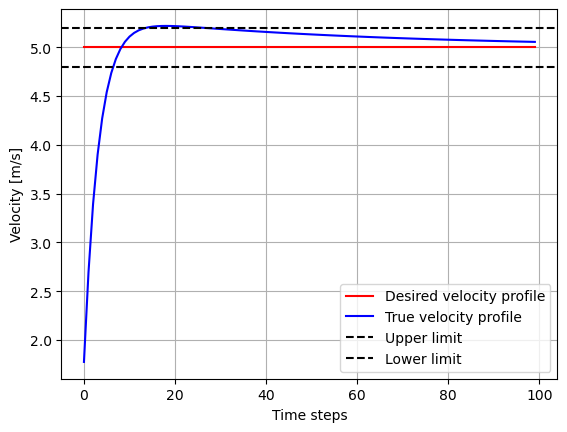

In [3]:
import ex8 as ex
import numpy as np
import matplotlib.pyplot as plt
import math

# Add code to test the PID controller

# TODO: initialize robot
robot = ex.Robot()
robot.x = 1
robot.y = 3
robot.theta = np.pi / 3
robot.v = 0
robot.delta = 0

# robot constraints
v_max = 10
delta_max = np.pi / 3
delta_dot_max = 0.175

# TODO: define the desired velocity, its limits and other needed variables
v_des = 5.0  # Desired velocity (m/s)
dt = 0.1     # Time step (s)
Kp, Ki, Kd = 3, 0.5, 0.05  # PID gains

# Initialize variables for PID controller
integral_error = 0.0
prev_error = 0.0
v_des_profile = [v_des] * 100
v_true_profile = []

# Run the controller
for _ in range(100):
    # Compute longitudinal control
    a_control, integral_error, prev_error = ex.longitudinal_controller(
        robot, v_des, Kp, Ki, Kd, dt, integral_error, prev_error
    )

    # Execute control action
    delta_dot = 0.0  # No steering for this test
    robot.apply_control(a_control, delta_dot, dt)

    # Update true velocity profile
    v_true_profile.append(robot.v)


# Plot trajectory
plt.plot(v_des_profile, "-r", label="Desired velocity profile")
plt.plot(v_true_profile, "-b", label="True velocity profile")
plt.axhline(v_des + 0.2, color="k", linestyle="--", label="Upper limit")
plt.axhline(v_des - 0.2, color="k", linestyle="--", label="Lower limit")
plt.legend()
plt.xlabel("Time steps")
plt.ylabel("Velocity [m/s]")
plt.grid(True)
plt.show()

## 8.2 Lateral Controller [6.0]

The goal of the lateral controller is to ensure that the steering angle $\delta$ is set such that the vehicle intersects the desired path at a look-ahead distance $l_d$ according to the pure-pursuit strategy explained in the lecture.

<img src="pure_pursuit.png" width="500">

Implement a lateral controller with $l_d = 2\,m$. The length of the car is $d = 1\,m$. Verify that your implementation is correct for some test input.

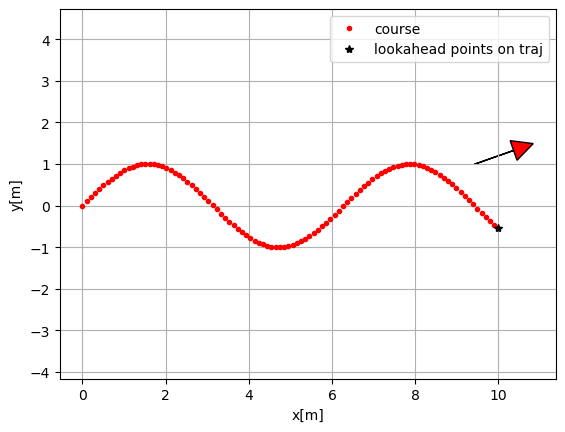

In [5]:
# Implement the lateral controller which sets the steering angle
# TODO: initialize robot

robot = ex.Robot()
robot.x = 0
robot.y = 0
robot.theta = 0
robot.v = 1.0  # Moving at a constant velocity

# TODO: define desired trajectory
x_des = np.linspace(0, 10, 100)  # Desired x-coordinates
y_des = np.sin(x_des)            # Desired y-coordinates (sine wave trajectory)

# TODO: compute the desired delta control 
# Parameters
ld = 2.0   # Look-ahead distance
d = 1.0    # Length of the car
dt = 0.1   # Time step

# Initialize lookahead visualization
lookx_list = []
looky_list = []

# Simulate the robot's motion
for _ in range(100):
    # Compute lateral control
    delta_dot, lookx, looky = ex.lateral_controller(robot, x_des, y_des, ld, d)

    # Apply control action
    robot.apply_control(0, delta_dot, dt)  # No acceleration

    # Save lookahead points for visualization
    lookx_list.append(lookx)
    looky_list.append(looky)

robot.apply_control(0, delta_dot, dt)

# Plot desired trajectory and relevant results
ex.plot_arrow(robot.x, robot.y, robot.theta)
plt.plot(x_des, y_des, ".r", label="course")
plt.plot(lookx, looky, "*k", label="lookahead points on traj")
plt.legend()
plt.xlabel("x[m]")
plt.ylabel("y[m]")
plt.axis("equal")
plt.grid(True)
plt.show()

## 8.3 Path Following Task [5.0]

Once you complete the above two functions, implement the procedure to follow the desired path as accurately as possible. The desired path to be followed is a curve provided in the code snippet. The desired linear velocity 
is $v_{des} = 2\,m/s$. The robot starts at an initial pose $x_0 = [0, 3, \pi/3]$.

Implement the function which uses the longitudinal and lateral controllers to follow the path. Run the simulation upto time T = 100 seconds or until the end of trajectory is reached. Assume that the controllers provide input at 10 Hz (i.e dt = 0.1). Plot the actual trajectory followed by the robot and overlay it with the desired trajectory.

Hints:
1. You may use the function `calculate_lookahead_index` to compute the index of the lookahead point along the trajectory. 
2. You may also play with the lookahead distance parameter $L_d$ to obtain better tracking results.

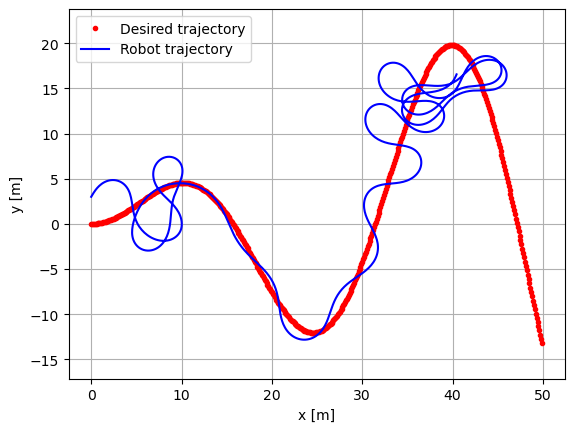

In [6]:
# Implement code to call the two implemented controllers to follow a dedired trajectory

# TODO: initialize robot
robot = ex.Robot()
robot.x = 0
robot.y = 3
robot.theta = np.pi / 3
robot.v = 0

# TODO: desired longitudinal velocity 
v_des = 2.0  # m/s

# desired trajectory
x_des = np.arange(0, 50, 0.1)
y_des = [math.sin(x_i / 5.0) * x_i / 2.0 for x_i in x_des]

# variables to record robot state
x_traj = [robot.x]
y_traj = [robot.y]
theta_traj = [robot.theta]
v_t = [robot.v]
delta_t = [robot.delta]

# set simulation time
T = 100
dt = 0.1 # 10Hz
t = 0

# Initialize variables for PID controller
integral_error = 0.0
prev_error = 0.0

# main loop
while t < T and robot.x < x_des[-1]:
    # Compute longitudinal control
    a_control, integral_error, prev_error = ex.longitudinal_controller(
        robot, v_des, Kp=1.0, Ki=0.1, Kd=0.05, dt=dt, integral_error=integral_error, prev_error=prev_error
    )

    # Compute lateral control
    delta_dot, lookx, looky = ex.lateral_controller(robot, x_des, y_des, ld=2.0, d=1.0)

    # Apply control commands to robot
    robot.apply_control(a_control, delta_dot, dt)

    # Update time
    t += dt

    # Save variables for plotting
    x_traj.append(robot.x)
    y_traj.append(robot.y)
    theta_traj.append(robot.theta)
    v_t.append(robot.v)
    delta_t.append(robot.delta)

# Plot trajectory
plt.cla()
plt.plot(x_des, y_des, ".r", label="Desired trajectory")
plt.plot(x_traj, y_traj, "-b", label="Robot trajectory")
plt.legend()
plt.xlabel("x [m]")
plt.ylabel("y [m]")
plt.axis("equal")
plt.grid(True)
plt.show()

## 8.4 Unfeasible Trajectory [3.0]

The desired trajectory of the preiovus exercise is not feasible due to the robot's constraints. Imagine that you can get a second robot, identical to the first one, but with different constraints. Define new limits for $v$, $|\delta|$ and $|\dot{\delta}|$, such as this robot can follow the desired trajectory and show the result.

_Hint:_ Use the previous code and try to change one limit at the time.

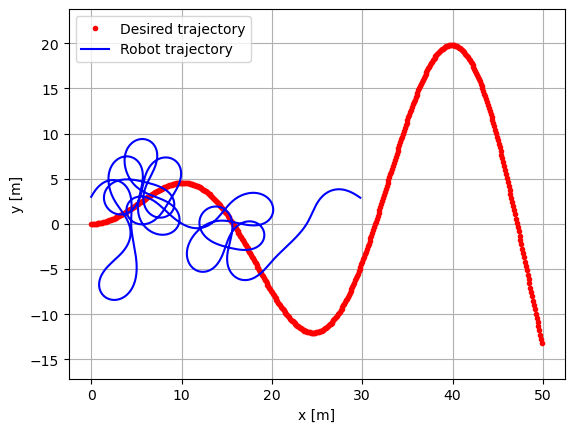

In [7]:
import ex8 as ex
import numpy as np
import matplotlib.pyplot as plt
import math

# Initialize the second robot
robot = ex.Robot()
robot.x = 0
robot.y = 3
robot.theta = np.pi / 3
robot.v = 0

# Desired longitudinal velocity
v_des = 2.0  # m/s

# Define new constraints for the second robot
v_max = 15.0        # Maximum velocity (m/s)
delta_max = np.pi/4 # Maximum steering angle (45 degrees)
delta_dot_max = 0.3 # Maximum steering rate (rad/s)

# Desired trajectory
x_des = np.arange(0, 50, 0.1)
y_des = [math.sin(x_i / 5.0) * x_i / 2.0 for x_i in x_des]

# Variables to record robot state
x_traj = [robot.x]
y_traj = [robot.y]
theta_traj = [robot.theta]
v_t = [robot.v]
delta_t = [robot.delta]

# Set simulation time
T = 100
dt = 0.1  # 10 Hz
t = 0

# Initialize variables for PID controller
integral_error = 0.0
prev_error = 0.0

# Simulation loop
while t < T and robot.x < x_des[-1]:
    # Compute longitudinal control
    a_control, integral_error, prev_error = ex.longitudinal_controller(
        robot, v_des, Kp=1.0, Ki=0.1, Kd=0.05, dt=dt, integral_error=integral_error, prev_error=prev_error
    )

    # Constrain the acceleration based on new limits
    a_control = max(min(a_control, v_max - robot.v), -v_max)

    # Compute lateral control
    delta_dot, lookx, looky = ex.lateral_controller(robot, x_des, y_des, ld=2.0, d=1.0)

    # Constrain steering rate based on new limits
    delta_dot = max(min(delta_dot, delta_dot_max), -delta_dot_max)

    # Apply control commands to the robot
    robot.apply_control(a_control, delta_dot, dt)

    # Constrain steering angle based on new limits
    robot.delta = max(min(robot.delta, delta_max), -delta_max)

    # Update time
    t += dt

    # Save variables for plotting
    x_traj.append(robot.x)
    y_traj.append(robot.y)
    theta_traj.append(robot.theta)
    v_t.append(robot.v)
    delta_t.append(robot.delta)

# Plot trajectory
plt.cla()
plt.plot(x_des, y_des, ".r", label="Desired trajectory")
plt.plot(x_traj, y_traj, "-b", label="Robot trajectory")
plt.legend()
plt.xlabel("x [m]")
plt.ylabel("y [m]")
plt.axis("equal")
plt.grid(True)
plt.show()
